In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.io.wavfile
from scipy.fftpack import dct
import IPython.display

%matplotlib inline

In [2]:
data_dir="../../raw"

In [3]:
filename=data_dir+"/OSR_us_000_0010_8k.wav"

## Read Sound File

In [4]:
sample_rate, signal0 = scipy.io.wavfile.read(filename)  # File assumed to be in the same directory
signal = signal0[int(17 * sample_rate):int(19.5 * sample_rate)]  # Keep 2.5 seconds, from 17 to 19.5 s on recording
signal.shape,len(signal)/sample_rate,sample_rate

((20000,), 2.5, 8000)

In [5]:
scipy.io.wavfile.write("./images/sample.wav",rate=sample_rate,data=signal)

### Input Signal in Time Domain

In [6]:
IPython.display.Audio(data=signal,rate=sample_rate)

In [7]:
T=np.arange(len(signal))/sample_rate

`signal` is just a `numpy` array of sound intensities

Text(0.5,0,'Time (s)')

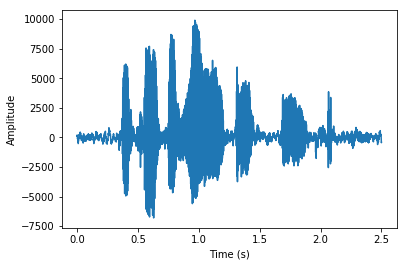

In [8]:
plt.plot(T,signal)
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")

Tha sound has very rapid oscilations

Text(0.5,0,'Time (s)')

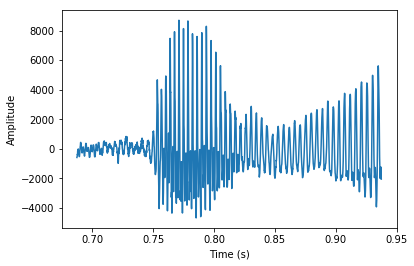

In [9]:

plt.plot(T[5500:7500],signal[5500:7500])
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")

## Emphasis

Sometimes a linear filter is applied to emphasis particular frequencies in the signal before
processing.

We skip that step

In [10]:
emphasized_signal=signal

## Framing
we break the sound into **frames** of 0.025s duration, separated from each other by a 0.01s **stride**.

In [11]:
frame_size = 0.025
frame_stride = 0.01

In [12]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame
print("signal lenght",signal_length)
print("frame_length",frame_length)
print("frame_step",frame_step)
print("num_frames",num_frames)
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames0 = pad_signal[indices.astype(np.int32, copy=False)]
frames0.shape

signal lenght 20000
frame_length 200
frame_step 80
num_frames 248


(248, 200)

## Apply a Hamming Window to frames

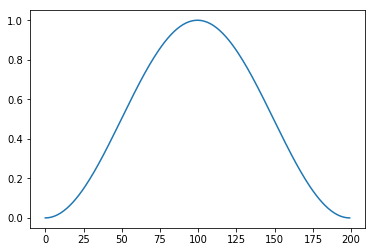

In [13]:
plt.plot(np.hanning(frame_length))

In [14]:
frames =frames0 *np.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

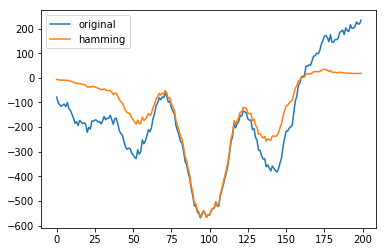

In [15]:
plt.plot(frames0[20],label="original")
plt.plot(frames[20],label="hamming")
plt.legend()

## Fourier-Transform and Power Spectrum

In [16]:
NFFT = 512

In [17]:
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
pow_frames.shape

(248, 257)

Text(0.5,0,'Time (s)')

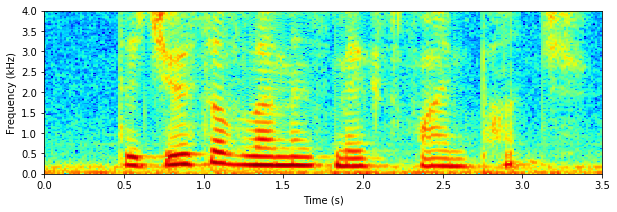

In [18]:
plt.figure(figsize=(10, 3))
plt.imshow(np.log(pow_frames.T),origin="lower",aspect="auto",cmap="jet", extent=[0,3.5,0,4])
#ax = plt.gca()
#ax.set_xticklabels(0,[0.5,1.,1.5,2.,2.5,3.])
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")

## Filter Banks

In [19]:
def generate_melbanks(nbanks,sample_rate,NFFT=512):
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nbanks + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nbanks, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nbanks + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    return fbank,high_freq_mel

First we create 10 Mel banks to make a readable plot

In [20]:
fbank0,high_mel=generate_melbanks(10,sample_rate,NFFT)
fbank0.shape,high_mel

((10, 257), 2146.06452750619)

Text(0,0.5,'Amplitude')

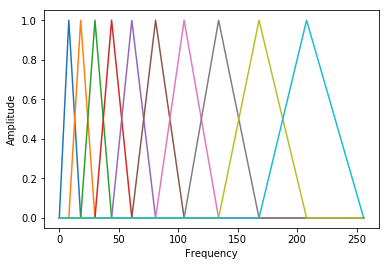

In [21]:
plt.plot(fbank0.T)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

For Signal processing we will use 40 banks instead

In [22]:
fbank,high_mel=generate_melbanks(40,sample_rate,NFFT)
fbank.shape,high_mel

((40, 257), 2146.06452750619)

### Mel Bank Application to Single Frame

In [23]:
frame=pow_frames[53]
frame.shape

(257,)

Text(0,0.5,'Mel Bank Log Amplitude')

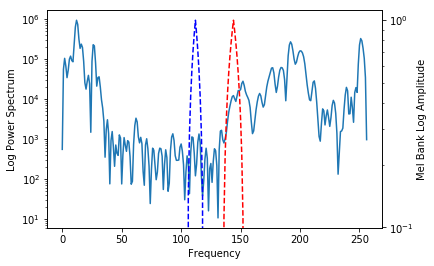

In [24]:
plt.semilogy(frame)

plt.ylabel("Log Power Spectrum")
plt.xlabel("Frequency")
ax1=plt.gca()
ax2=ax1.twinx()
ax2.semilogy(fbank[26],color="b",linestyle="--")
ax2.semilogy(fbank[30],color="r",linestyle="--")
ax2.set_ylabel("Mel Bank Log Amplitude")

## MEL Spectrogram

In [25]:
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB
filter_banks.shape

(248, 40)

Text(0.5,0,'Time (s)')

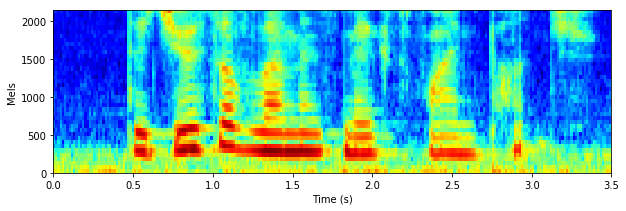

In [26]:
plt.figure(figsize=(10, 3))
plt.imshow(filter_banks.T,origin="lower",aspect="auto",cmap="jet", extent=[0,3.5,0,high_mel])
#ax = plt.gca()
#ax.set_xticklabels(0,[0.5,1.,1.5,2.,2.5,3.])
plt.ylabel("Mels")
plt.xlabel("Time (s)")

## Mel-frequency Cepstral Coefficients (MFCCs)

### Smothing of the Mel Frequency Coefficients

Mel coefficients for a single frame

In [27]:
num_ceps = 20

In [28]:
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

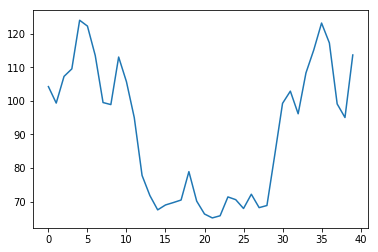

In [29]:
plt.plot(filter_banks[53])

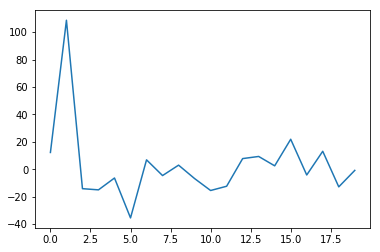

In [30]:
plt.plot(mfcc[53])

Text(0.5,0,'Time (s)')

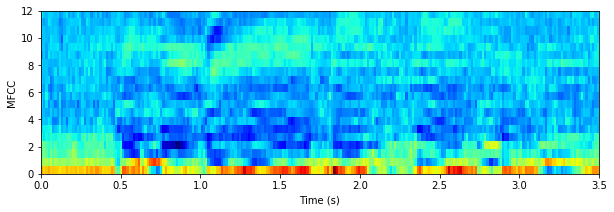

In [31]:
plt.figure(figsize=(10, 3))
plt.imshow(mfcc.T,origin="lower",aspect="auto",cmap="jet", extent=[0,3.5,0,12])
plt.ylabel("MFCC")
plt.xlabel("Time (s)")